In [2]:
## load news data from database into dataframe anc cluster with https://towardsdatascience.com/all-the-news-17fa34b52b9d

In [3]:
import sys
for p in sys.path:
    print(p)

/workspaces/data-app/app/news_clustering
/usr/local/lib/python311.zip
/usr/local/lib/python3.11
/usr/local/lib/python3.11/lib-dynload

/home/vscode/.local/lib/python3.11/site-packages
/usr/local/lib/python3.11/site-packages


In [4]:
sys.path.insert(0,'/workspaces/data-app/app/database')

In [5]:
import psycopg2
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
from database import Database

In [6]:
# preprocessing
import re
import sys
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from collections import Counter
import time

# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# clustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [7]:
database = Database()
database.open_connection()

In [8]:
## get articles table into datframe
sql = "SELECT * FROM articles;"
articles = sqlio.read_sql_query(sql, database.connection)
database.close_connection()

/tmp/ipykernel_586/2993504995.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  articles = sqlio.read_sql_query(sql, database.connection)


In [9]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   urlid              82 non-null     object        
 1   headline           82 non-null     object        
 2   content            82 non-null     object        
 3   authors            82 non-null     object        
 4   uploadtimestamp    82 non-null     datetime64[ns]
 5   imageurl           82 non-null     object        
 6   imagedescription   82 non-null     object        
 7   scrapingtimestamp  82 non-null     datetime64[ns]
 8   source             82 non-null     object        
 9   topic              82 non-null     object        
dtypes: datetime64[ns](2), object(8)
memory usage: 6.5+ KB


## Plan:
### 1) stemming -> done
### 2) create word matrix -> done
### 3) TFIDF -> done
### 4) Clustering -> done
### 5) majority vote of attribute topic within clusters to be used as cluster's topic
### a) add empty columns cluster_id, cluster_topic -> done
### b) vote topic
### c) write into database

In [10]:
# Data Analytics preprocessing

# Option A

# Preprocessing
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stopwords.words("english")]  # Remove stopwords
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]  # Stem words
    return ' '.join(words)


In [11]:
# Option B

# Preprocessing
def preprocess_lemmatizer(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [word for word in words if word not in stopwords.words("english")]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Stem words
    return ' '.join(words)

In [12]:
preprocessed_articles = articles.content.apply(lambda x: preprocess(x))
print(preprocessed_articles[0])

front line ukrain alli hope summer breakthrough epitom bleak dark winter ahead russian resurg kyiv mount loss like say armi plan good paper forgot trench joke ihor command th nation guard cnn use first name protect ident secur reason speak cnn deep command post orikhiv southern ukrain interrupt panick nois radio room heavili injur radio oper shout russian drone hit larg ga fuel tank use heat trench close russian posit leav one soldier hurt ihor grab handset begin evacu begin evacu evacu small vehicl move alreadi voic radio repli cannot evacu lack transport ihor face tighten frustrat wait news agon silenc minut later radio crackl soldier alreadi militari code dead ihor tell men rush cant help bodi sergei age collect dark safer one four ukrainian soldier kill day week area alon accord ukrainian offici area everi casualti make differ said ihor affect everyon moral pain winter fight beyond bleak north robotyn fierc fight rage month ago ukrainian drone outnumb russian one latter hit one ukr

In [13]:
preprocessed_lemmatized_articles = articles.content.apply(lambda x: preprocess_lemmatizer(x))
print(preprocessed_lemmatized_articles[0])

front line ukraine ally hoped summer breakthrough epitomize bleak dark winter ahead russian resurgence kyivs mounting loss like say army plan good paper forgot trench joked ihor commander th national guard cnn using first name protect identity security reason speaking cnn deep command post orikhiv southern ukraine interrupted panicked noise radio room heavily injured radio operator shout russian drone hit large gas fuel tank used heating trench close russian position leaving one soldier hurt ihor grab handset begin evacuation begin evacuation evacuate small vehicle move already voice radio reply cannot evacuate lack transport ihors face tightens frustration wait news agonizing silence minute later radio crackle soldier already military code dead ihor tell men rush cant help body sergei aged collected dark safer one four ukrainian soldier killed day week area alone according ukrainian official area every casualty make difference said ihor affect everyones morale painful winter fight bey

In [14]:
# Option B
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(preprocessed_lemmatized_articles)

In [15]:
tfidf_matrix.get_shape

<bound method spmatrix.get_shape of <82x9846 sparse matrix of type '<class 'numpy.float64'>'
	with 27874 stored elements in Compressed Sparse Row format>>

In [16]:
# dimensionality reduction (100 is known to be good approximation)
svd = TruncatedSVD(n_components=100)
tfidf_matrix_svd = svd.fit_transform(tfidf_matrix)

## Adjust number of clusters automatically!!!

In [17]:
silhouette_avg = []
for num_clusters in list(range(2,len(articles))):
    kmeans = KMeans(n_clusters=num_clusters, init = "k-means++", n_init = 10)
    kmeans.fit_predict(tfidf_matrix_svd)
    score = silhouette_score(tfidf_matrix_svd, kmeans.labels_)
    silhouette_avg.append(score)

print (f"Best K: {np.argmax(silhouette_avg)+2}")

Best K: 42


In [18]:
best_k = np.argmax(silhouette_avg) + 2 # type: ignore

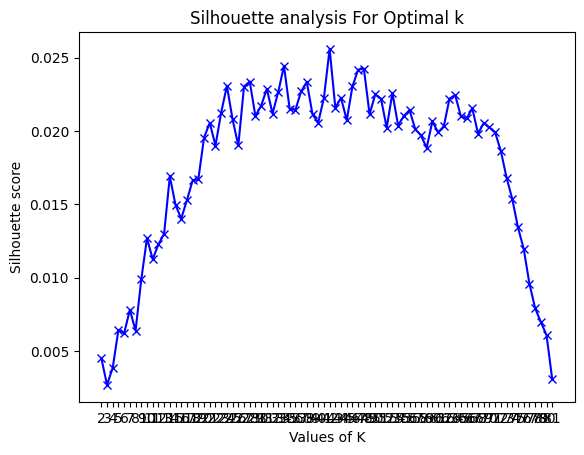

In [19]:
plt.plot(np.arange(2,len(articles)),silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
_ = plt.xticks(np.arange(2,len(articles)))

# Clustering

In [20]:
clf = KMeans(n_clusters=best_k, verbose = 0)
clf.fit(tfidf_matrix_svd)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=42)

In [21]:
articles['clusterId'] = clf.labels_

In [22]:
articles['clusterId']

0     12
1      6
2      6
3      2
4     29
      ..
77    18
78    10
79    14
80     2
81     1
Name: clusterId, Length: 82, dtype: int32

In [24]:
#articles.drop(columns='clusterTopic', inplace=True)
articles.head()

,urlid,headline,content,authors,uploadtimestamp,imageurl,imagedescription,scrapingtimestamp,source,topic,clusterId
0,https://edition.cnn.com/2023/12/19/europe/ukra...,"\n Gas, drones and convict recruits: Ukra...",\n The front lines where Ukraine and its...,{},2023-12-19 03:59:00,https://media.cnn.com/api/v1/images/stellar/pr...,screengrab npw ukraine front line,2023-12-19 13:32:22.237949,cnn,world,12
1,https://edition.cnn.com/2023/12/19/middleeast/...,\n ‘Beyond desperate’ situation for Chris...,\n The situation has become “beyond desp...,"{""Isa Soares"",""Heather Chen""}",2023-12-18 23:38:00,https://media.cnn.com/api/v1/images/stellar/pr...,Isa Soares,2023-12-19 13:32:24.246686,cnn,world,6
2,https://edition.cnn.com/2023/12/19/middleeast/...,\n Who are the Houthis and why are they a...,\n Yemen’s Iran-backed Houthi rebels are...,"{""Christian Edwards""}",2023-12-19 06:41:00,https://media.cnn.com/api/v1/images/stellar/pr...,FILE PHOTO: Armed men stand on the beach as th...,2023-12-19 13:32:36.208124,cnn,world,6
3,https://edition.cnn.com/2023/12/18/americas/5-...,\n Rescuers battle sub-zero temperatures ...,\n At least 126 people were killed and h...,"{""Nectar Gan"",""Mengchen Zhang"",""Wayne Chang"",""...",2023-12-19 08:19:00,https://media.cnn.com/api/v1/images/stellar/pr...,Nectar Gan,2023-12-19 13:32:48.682670,cnn,world,2
4,https://edition.cnn.com/2023/12/18/europe/reyk...,\n Volcano erupts on Iceland’s Reykjanes ...,\n A volcano has dramatically erupted in...,"{""Mitchell McCluskey"",""Taylor Ward"",""Jessie Ye...",2023-12-19 07:49:00,https://media.cnn.com/api/v1/images/stellar/pr...,Taylor Ward,2023-12-19 13:33:15.720832,cnn,world,29


# Majority voting

In [25]:
articles['clusterTopic'] = None

for index, article in articles.iterrows():
    cluster = article['clusterId']
    currentdf = articles.loc[articles['clusterId'] == cluster]
    articles['clusterTopic'][index] = currentdf.topic.mode()[0]

articles.head()

/tmp/ipykernel_586/59058516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['clusterTopic'][index] = currentdf.topic.mode()[0]
/tmp/ipykernel_586/59058516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['clusterTopic'][index] = currentdf.topic.mode()[0]
/tmp/ipykernel_586/59058516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles['clusterTopic'][index] = currentdf.topic.mode()[0]
/tmp/ipykernel_586/

,urlid,headline,content,authors,uploadtimestamp,imageurl,imagedescription,scrapingtimestamp,source,topic,clusterId,clusterTopic
0,https://edition.cnn.com/2023/12/19/europe/ukra...,"\n Gas, drones and convict recruits: Ukra...",\n The front lines where Ukraine and its...,{},2023-12-19 03:59:00,https://media.cnn.com/api/v1/images/stellar/pr...,screengrab npw ukraine front line,2023-12-19 13:32:22.237949,cnn,world,12,sport
1,https://edition.cnn.com/2023/12/19/middleeast/...,\n ‘Beyond desperate’ situation for Chris...,\n The situation has become “beyond desp...,"{""Isa Soares"",""Heather Chen""}",2023-12-18 23:38:00,https://media.cnn.com/api/v1/images/stellar/pr...,Isa Soares,2023-12-19 13:32:24.246686,cnn,world,6,world
2,https://edition.cnn.com/2023/12/19/middleeast/...,\n Who are the Houthis and why are they a...,\n Yemen’s Iran-backed Houthi rebels are...,"{""Christian Edwards""}",2023-12-19 06:41:00,https://media.cnn.com/api/v1/images/stellar/pr...,FILE PHOTO: Armed men stand on the beach as th...,2023-12-19 13:32:36.208124,cnn,world,6,world
3,https://edition.cnn.com/2023/12/18/americas/5-...,\n Rescuers battle sub-zero temperatures ...,\n At least 126 people were killed and h...,"{""Nectar Gan"",""Mengchen Zhang"",""Wayne Chang"",""...",2023-12-19 08:19:00,https://media.cnn.com/api/v1/images/stellar/pr...,Nectar Gan,2023-12-19 13:32:48.682670,cnn,world,2,world
4,https://edition.cnn.com/2023/12/18/europe/reyk...,\n Volcano erupts on Iceland’s Reykjanes ...,\n A volcano has dramatically erupted in...,"{""Mitchell McCluskey"",""Taylor Ward"",""Jessie Ye...",2023-12-19 07:49:00,https://media.cnn.com/api/v1/images/stellar/pr...,Taylor Ward,2023-12-19 13:33:15.720832,cnn,world,29,world


## Write clusterIds and clusterTopics into database

In [29]:
database = Database()
database.open_connection()

In [30]:
for index, row in articles.iterrows():
    try:
        database.execute('''UPDATE articles
                            SET clusterId = %s, clusterTopic = %s
                            WHERE urlid = %s''',
                            (row.clusterId,
                             row.clusterTopic,
                             row.urlid
                            )
                        )
    except BaseException as ex:
        print('Different Error: ', ex)

In [ ]:
database.close_connection()